### 4.4.2 过拟合问题
**过拟合：当一个模型过于复杂之后，它可以很好地“记忆”每一个训练数据中随机噪音的部分而忘记了要去“学习”训练数据中通用的趋势。**
<p align='center'>
    <img src=images/图4.14.JPG>
</p>

为了避免过拟合，一个非常常用的方法是**“正则化(regularization)”，其思想就是在损失函数中加入刻画模型复杂程度的指标。**假设用于刻画模型在训练数据上表现得损失函数使$J(\theta)$，那么**在优化时不是直接优化$J(\theta)$，而是优化$J(\theta) + \lambda R(w)$**，其中：
- $R(w)$刻画的是模型得复杂度；
- $\lambda$表示模型复杂度损失在总损失中得比例；
- $\theta$表示的是整个神经网络中得所有参数，包括边上的权重和偏执项b，一般来说模型复杂度只有权重$w$决定。

常用的刻画模型复杂度的函数$R(w)$有两种：
- **L1正则**：$R(w) = ||w||_1 = \sum_i{|w_i|}$
- **L2正则**：$R(w) = ||w||_2^2 = \sum_i{|w_i^2|}$
- 实践中也可同时使用：$R(w) = \sum_i{\alpha|w_i| + (1 - \alpha)w_i^2}$

两种正则的思想都是希望通过限制权重的大小，使得模型不能任意拟合训练数据中的噪音。但两种方法有着很大的**区别**：
- L1正则会让参数变得稀疏（即有更多的参数变为0），这样可以达到特征选取的功能，另外计算公式不可导；
- L2正则则不会让参数变得稀疏（原因是参数很小时如0.001，其平方项就基本可以忽略于是模型不会进一步调整参数为0），其计算公式可导，优化更简洁。

一个带L2正则化的损失函数的例子：`loss = tf.reduce_mean(tf.square(y_ - y)) + tf.contrib.layers.l2_regularizer(lambda)(w)`，运行样例如下：

In [1]:
import tensorflow as tf

weights = tf.constant([[1.0, -2.0], [-3.0, 4.0]])

with tf.Session() as sess:
    # 输出为（|1| + |-2| + |-3| + |4|） * 0.5 = 5，其中0.5为正则化项的权重
    print(sess.run(tf.contrib.layers.l1_regularizer(.5)(weights)))
    # 输出为（1^2 + (-2)^2 + (-3)^2 + 4^2/2） * 0.5 = 7.5，TF会将L2的正则化损失值除以2使得求导更简洁
    print(sess.run(tf.contrib.layers.l2_regularizer(.5)(weights)))

5.0
7.5


在简单的神经网络中，这样的方式就可以很好地计算正则化带来的损失函数了。**但当神经网络的参数增加后，这样的方式会导致损失函数loss的定义很长，可读性差且容易出错。更主要的是，当网络结构复杂之后定义网络结构的部分和计算损失函数的部分可能不在同一函数中，这样通过变量这种方式计算损失函数就不方便了**。为解决这个问题，可以适用TensorFlow中的集合（Collection），之前在3.1节中已经介绍过，它可以在一个计算图中保存一组实体（比如张量），参见下面这个例子：

#### 1. 生成模拟数据集。

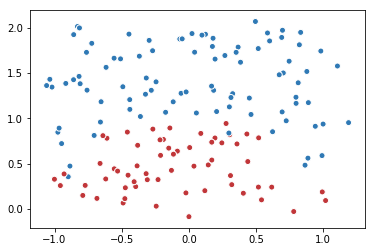

In [2]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

data = []
label = []
np.random.seed(0)

# 以原点为圆心，半径为1的圆把散点划分成红蓝两部分，并加入随机噪音。
for i in range(150):
    x1 = np.random.uniform(-1, 1)
    x2 = np.random.uniform(0, 2)
    data.append([np.random.normal(x1, 0.1), np.random.normal(x2, 0.1)])
    if x1**2 + x2**2 <= 1: 
        label.append(0)
    else:
        label.append(1)

data = np.hstack(data).reshape(-1, 2)
label = np.hstack(label).reshape(-1, 1)
plt.scatter(data[:,0], data[:,1], c=label.flatten(),
           cmap="RdBu", vmin=-.2, vmax=1.2, edgecolor="white")
plt.show()

#### 2. 定义一个获取权重，并自动加入正则项到损失的函数。

In [3]:
def get_weight(shape, lambda1):
    w = tf.Variable(tf.random_normal(shape), dtype=tf.float32)
    # tf.add_to_collection将这个新生成的L2正则项损失项加入集合
    tf.add_to_collection('losses', tf.contrib.layers.l2_regularizer(lambda1)(w))
    return w

#### 3. 定义神经网络。

In [4]:
x = tf.placeholder(tf.float32, shape=(None, 2))
y_ = tf.placeholder(tf.float32, shape=(None, 1))
sample_size = len(data)

# 每层节点的个数
layer_dimension = [2, 10, 5, 3, 1]

n_layers = len(layer_dimension)

# 这个变量维护前向传播时最深层的节点，开始的时候是输入层
cur_layer = x
in_dimension = layer_dimension[0]

# 循环生成网络结构
for i in range(1, n_layers):
    out_dimension = layer_dimension[i]
    weight = get_weight([in_dimension, out_dimension], 0.003)
    bias = tf.Variable(tf.constant(0.1, shape=[out_dimension]))
    cur_layer = tf.nn.elu(tf.matmul(cur_layer, weight) + bias)
    in_dimension = layer_dimension[i]

y = cur_layer

# 损失函数的定义
mse_loss = tf.reduce_sum(tf.pow(y_ - y, 2)) / sample_size
tf.add_to_collection('losses', mse_loss)
# tf.get_collection返回一个列表，这个列表是所有这个集合中的元素，将它们加起来就是最终的损失函数
loss = tf.add_n(tf.get_collection('losses'))

#### 4. 训练不带正则项的损失函数mse_loss。

After 0 steps, mse_loss: 16.743280
After 2000 steps, mse_loss: 0.068184
After 4000 steps, mse_loss: 0.053223
After 6000 steps, mse_loss: 0.042781
After 8000 steps, mse_loss: 0.027724
After 10000 steps, mse_loss: 0.020303
After 12000 steps, mse_loss: 0.017723
After 14000 steps, mse_loss: 0.015720
After 16000 steps, mse_loss: 0.014346
After 18000 steps, mse_loss: 0.013058
After 20000 steps, mse_loss: 0.012400
After 22000 steps, mse_loss: 0.011919
After 24000 steps, mse_loss: 0.011422
After 26000 steps, mse_loss: 0.008267
After 28000 steps, mse_loss: 0.007951
After 30000 steps, mse_loss: 0.007481
After 32000 steps, mse_loss: 0.007388
After 34000 steps, mse_loss: 0.007321
After 36000 steps, mse_loss: 0.007272
After 38000 steps, mse_loss: 0.007582


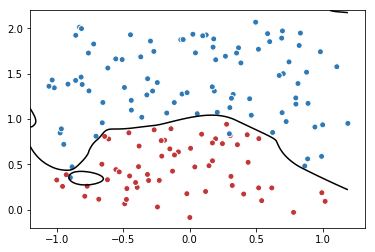

In [5]:
# 定义训练的目标函数mse_loss，训练次数及训练模型
train_op = tf.train.AdamOptimizer(0.001).minimize(mse_loss)
TRAINING_STEPS = 40000

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    for i in range(TRAINING_STEPS):
        sess.run(train_op, feed_dict={x: data, y_: label})
        if i % 2000 == 0:
            print("After %d steps, mse_loss: %f" % (i, sess.run(mse_loss, feed_dict={x: data, y_: label})))

    # 将整个区间grid，预测每点的概率，并reshape
    xx, yy = np.mgrid[-1.2:1.2:.01, -0.2:2.2:.01]  # 生成两个grid数据，也可通过“np.linspace/np.arange+列表内涵”实现这两行功能
    grid = np.c_[xx.ravel(), yy.ravel()]  # 将两个grid降为一维后按列拼接。ravel和flatten区别：后者返回拷贝，而前者返回视图，更改时会改变原数据
    probs = sess.run(y, feed_dict={x:grid})
    probs = probs.reshape(xx.shape)

plt.scatter(data[:,0], data[:,1], c=label.flatten(),
           cmap="RdBu", vmin=-.2, vmax=1.2, edgecolor="white")
plt.contour(xx, yy, probs, levels=[.5], cmap="Greys", vmin=0, vmax=.1) # 根据gird点的概率画出分割曲线，这里利用等高线实现，以0.5为分界线
plt.show()

#### 5. 训练带正则项的损失函数loss。

After 0 steps, loss: 2.599489
After 2000 steps, loss: 0.107390
After 4000 steps, loss: 0.069309
After 6000 steps, loss: 0.057962
After 8000 steps, loss: 0.056678
After 10000 steps, loss: 0.056366
After 12000 steps, loss: 0.056070
After 14000 steps, loss: 0.055973
After 16000 steps, loss: 0.055933
After 18000 steps, loss: 0.055894
After 20000 steps, loss: 0.055890
After 22000 steps, loss: 0.055887
After 24000 steps, loss: 0.055886
After 26000 steps, loss: 0.055885
After 28000 steps, loss: 0.055885
After 30000 steps, loss: 0.055885
After 32000 steps, loss: 0.055885
After 34000 steps, loss: 0.055884
After 36000 steps, loss: 0.055884
After 38000 steps, loss: 0.055884


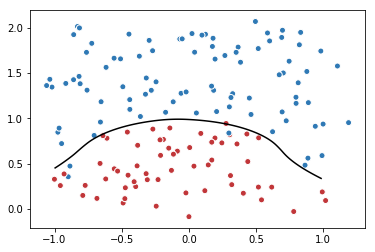

In [6]:
# 定义训练的目标函数loss，训练次数及训练模型
train_op = tf.train.AdamOptimizer(0.001).minimize(loss)
TRAINING_STEPS = 40000

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    for i in range(TRAINING_STEPS):
        sess.run(train_op, feed_dict={x: data, y_: label})
        if i % 2000 == 0:
            print("After %d steps, loss: %f" % (i, sess.run(loss, feed_dict={x: data, y_: label})))

    # 将整个区间grid，预测每点的概率，并reshape       
    xx, yy = np.mgrid[-1:1:.01, 0:2:.01]
    grid = np.c_[xx.ravel(), yy.ravel()]
    probs = sess.run(y, feed_dict={x:grid})
    probs = probs.reshape(xx.shape)

plt.scatter(data[:,0], data[:,1], c=label.flatten(),
           cmap="RdBu", vmin=-.2, vmax=1.2, edgecolor="white")
plt.contour(xx, yy, probs, levels=[.5], cmap="Greys", vmin=0, vmax=.1)
plt.show()